# Vaccines Trade Network: Analysis and Forecasting with ARIMA and Recurrent Neural Networks
### Author: Georgios Spyrou
### Date: 27/06/2020

<img src="https://www.our-voices.org.uk/assets/images/Network-diagram.png" width=520 height=240 />

## Project Purpose

Scope of this project is to replicate the global trade network of human vaccines around the globe for a variety of years (current data span from 2010 to 2019. Through plotting and statistical analysis, we want to identify informative patterns on how different countries change their import/export activity throughout the years.

## Part 1: Data Retrieval

In order to find and retrieve data we have utilised the UN Comtrade API (https://comtrade.un.org/Data/). This is a great place if someone wants to find data regarding exports/impors of countries around the world, pretty much for any product/service. The data are very well documented and visualized on the website, and it's easy to do some exploration  and locate data that seem interesting for your project.

Therefore, after I managed to identify the relevant data that I wanted to work with (vaccines for human medicine), I had to find a way to leverage the API to get my data. Even though the website allows us to download sample CSV files, if we wanted to do that for multiple years and countries it would take a lot of time. Hence, I have decided to approach the data retrieval from a Python standpoint in order to automate this task.

Before we jump to the part of how we are going to automate the data retrieval, it might worths it to explain what exactly we are aiming to retrieve.


The UN Comtrade database is giving us the opportunity to pick from a plethora of goods and services. My first task was to find the specific code that corresponds to human vaccines. After a bit of research we have found that this code is *300220*, which is a unique value that will allow us to only pick data for this good/product. After we located our product code, we have to decide on the time range that we want to pick data for. This can quickly get tricky as the database does not allow you to pick many years/countries all at once. But for now lets say that the scope of interest was *monthly* data from 2010 to 2019, for as many countries as possible - mainly because there are countries which do not seem to import/export vaccines or we do not have relevant information about them.

In [2]:
import requests
import csv
import json
import time
import os

# Setting up the parameters for the API calls to receive the data
max_rec = 100000
output_fmt = 'csv'
trade_type = 'C'            # Commodities
frequency = 'M'             # Monthly
px = 'HS'                   # Classification for products
cc = 300220                 # Subcategory --> 300220 code for Vaccines
reporter = 'all'
partner = 'all'                 
rg ='all'

# Connection string to comtrade.un.org based on the parameters above
api_call_string = f'http://comtrade.un.org/api/get?max={max_rec}&type={trade_type}&freq={frequency}&px={px}&ps=year&r=reporter&p={partner}&rg={rg}&cc={cc}&fmt={output_fmt}'

After we set up the string that will be used to do the appropriate API calls, it's time create a function that will use this string to retrieve the data and generate the csv files.

In [ ]:
def getDataCall(api_string: str, reporterid: str, reportername: str, year: int, out_folder: str) -> None:
    """
    Create a .csv file that contains the monthly data as received from  https://comtrade.un.org/Data/, for a specific year.

    Args:
    ----
        api_string: String that contains the URL for the API call. The string already contains all the paremeters required for the call.
        reporterid, reportername: Id and Name of the country of interest.
        year: Specify year of interest.
    Returns:
    -------
        None: The output is a .csv file that contains the data for a specified year.
    """
    csv_by_year_out_loc = os.path.join(out_folder, f'{year}')
    if not os.path.exists(csv_by_year_out_loc):
        os.makedirs(name=csv_by_year_out_loc)

    api_string = api_string.replace('year', f'{year}').replace('reporter', f'{reporterid}')
    print(api_string)

    response = requests.get(url=api_string, verify=False)

    if response.status_code != 200:
        print('Could not access the API!')
    else:
        decoded_data = response.content.decode('utf-8')
        csv_file = csv.reader(decoded_data.splitlines())
        datalines = list(csv_file)

        with open(os.path.join(csv_by_year_out_loc, f'Comtrade_Vaccines_Data_{reportername}_{year}.csv'), 'w', newline='') as f:
            writer = csv.writer(f, delimiter=',')
            writer.writerows(datalines)

Note that this call will run for *each* country, therefore we will end up with a lot of csv files. The country codes can be found here: https://comtrade.un.org/Data/cache/reporterAreas.json

In [ ]:
reporters_url = 'https://comtrade.un.org/Data/cache/partnerAreas.json'
reporters_resp = requests.get(url=reporters_url)
json_data = json.loads(reporters_resp.text)

reporters_list = [rep for rep in json_data['results']]

# Get the data as separate csv files, each for every year of interest
years_ls = [2017]
outputFilesFolder = f'CSVFiles\\'

In [ ]:
for api_check, repd in enumerate(reporters_list):
    # Need to make the script to sleep every 100 calls, as the API is blocking us for an hour for every 100 calls.
    if api_check !=0 and api_check % 100 == 0:
        time.sleep(3600)
    countryname = repd['text']
    c_id = repd['id']
    print(f'\nCountry..: {countryname}')
    for year in years_ls:
        print(f'\nReceiving the data for {year} from https://comtrade.un.org/...\n')
        getDataCall(api_call_string, reporterid=c_id, reportername=countryname, year=year, out_folder=outputFilesFolder)
        time.sleep(6)

At this point, we have successfully get the data for every country that we cound find a corresponding country code. That said, as we mentioned before there are some countries that contain no data for a specific year - which is might be for many reasons but this is out of the scope of this project. Hence, after we have ended up with multiple csv files , one for each country , we can repeat this process for as many years as we want to. I have repeated it for years from 2010 to 2019.

As you can probably imagine this process generated over 1000 csv files (10 years x over 100 countries). Hence it was necessary to perform some data cleaning operations in the directory that the files were created. The main task was to merge all this files for a specific year (e.g. all countries for 2017 merged to a common csv file), and at the same time delete all the files from the directory that contained no data.

In order to do that we have created a script to automatically do this for us, but as it might not be that of an interesting task we are going to leave it outside of this notebook. That said, the code that completes this can be found here: https://github.com/gpsyrou/Vaccines_Trade_Network/blob/master/dataCleaning.py

## Part 2: Exploratory Data Analysis & Data Cleaning

Now that we have our data organized into separate csv files by year, we can start the task of exploring what we actually got from the data retriaval process.

**Note**: Frow now on you are going to see two packages, one named _Functions_ and one named _VaccinesTradeNetworkClass_. Please note that these are custom packages that I have created for the purposes of this project. The first one contains some functions that we will keep using for our EDA tasks, while the VaccinesTradeNetworkClass one will be used later on, when we jump into creating out network graph as well as the time series objects.

In [1]:
import os
import pandas as pd
import numpy as np

project_dir = 'C:\\Users\\george\\Desktop\\GitHub\\Projects\\Comtrade_Network'
os.chdir(project_dir)

import warnings
warnings.filterwarnings('ignore')

# Custom packages
from Functions import tradeNetworkFunctions as tnf
from VaccinesTradeNetworkClass import VaccinesTradeNetwork

# Plotting and graphs
import matplotlib.pyplot as plt
import seaborn as sns

csv_files_loc = os.path.join(project_dir, 'Merged_CSVs')
maindf = pd.concat([pd.read_csv(os.path.join(csv_files_loc, file)) for file in os.listdir(csv_files_loc)])

At this stage we need to explore the dataset and identify any potential issues in the data tha require cleaning, and also make sure that we understand the features.


In [2]:
summary = maindf.describe()
summary

,Year,Period,Aggregate Level,Is Leaf Code,Trade Flow Code,Reporter Code,Reporter ISO,Partner Code,Partner ISO,2nd Partner Code,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
count,174733.000000,174733.000000,174733.0,174733.0,174733.000000,174733.000000,0.0,174733.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.459460e+05,0.0,1.747330e+05,0.0,0.0,174733.0
mean,2014.509721,201457.467548,6.0,1.0,1.573652,430.022137,NaN,383.477483,NaN,NaN,...,NaN,NaN,NaN,NaN,2.202360e+04,NaN,5.059609e+06,NaN,NaN,0.0
std,2.784246,278.388706,0.0,0.0,0.534287,269.904852,NaN,280.672337,NaN,NaN,...,NaN,NaN,NaN,NaN,1.922478e+06,NaN,3.375567e+07,NaN,NaN,0.0
min,2010.000000,201001.000000,6.0,1.0,1.000000,8.000000,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,NaN,0.0
25%,2012.000000,201208.000000,6.0,1.0,1.000000,208.000000,NaN,124.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,5.000000e+01,NaN,1.596700e+04,NaN,NaN,0.0
50%,2015.000000,201502.000000,6.0,1.0,2.000000,392.000000,NaN,364.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,3.650000e+02,NaN,1.376720e+05,NaN,NaN,0.0
75%,2017.000000,201705.000000,6.0,1.0,2.000000,699.000000,NaN,643.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,2.100000e+03,NaN,1.016600e+06,NaN,NaN,0.0
max,2019.000000,201912.000000,6.0,1.0,4.000000,894.000000,NaN,899.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,4.681763e+08,NaN,1.867086e+09,NaN,NaN,0.0


As we can see from the summary, few of the features does not seem to provide useful information for our analysis, as they either contain only empty values (e.g. 'Qty') or they contain fixed values (e.g.'Aggregate Level'). Therefore we will exclude the useless columns from our dataset to reduce the noise and the dimensions of our feature space.

Note: More information regarding the feautures can be found here: https://comtrade.un.org/data/MethodologyGuideforComtradePlus.pdf

In [3]:
useful_features_ls = ['Year', 'Period', 'Reporter Code', 'Reporter', 'Partner Code',
                      'Partner', 'Trade Flow', 'Commodity', 'Netweight (kg)',
                      'Trade Value (US$)']
df = maindf[useful_features_ls]

In [4]:
df['Trade Flow'].unique()

array(['Imports', 'Exports', 'Re-exports', 'Re-imports'], dtype=object)

We will consider both 'Re-imports' and 'Re-exports' as 'Imports' and 'Exports' respectively and we will drop the entries where we dont have info about the trade flow.

In [5]:
trade_flow_dict = {'Re-imports':'Imports', 
                   'Re-exports':'Exports',
                   'Imports':'Imports', 
                   'Exports':'Exports'}

df['Trade Flow'] = df['Trade Flow'].map(trade_flow_dict)

In [6]:
df.Partner.unique()

df['Partner'].replace(
    to_replace='United States of America',
    value='USA',
    inplace=True
)

df['Reporter'].replace(
    to_replace='United States of America',
    value='USA',
    inplace=True
)

Now we can observe that we have a node called 'World' but we would like to  analyze the trade relationships between specific countries. Thus we will exclude from the analysis the cases where the reporter or partner is 'World'. Finally, **Period** will be the column that identifies the specific datetime.


In [7]:
df = df[df.Partner != 'World']

df['Period'] = pd.to_datetime(df['Period'], format='%Y%m')

Except the nodes of our analysis which will correspond to countries, the other main features of interest are the **Netweight** of the export/import in kilograms as well as the **Trade Value in US dollars($)**.

Now we are in a position that we can start doing some data visualization to get a better understanding of our dataset. Therefore, lets find the top countries that import/export vaccines in terms of US dollars($).

In [8]:
# Specify the top-n number of countries that we want to plot for
topn = 15

At this point its necessary to introduce two functions for our EDA analysis. One function is being used in order to calculate the statistics of interest, while the second one is to plot the results. Both of these functions our packaged in *Functions* as we mentioned above, but as they might be interesting we are also going to include them into this notebook.

In [9]:
def getAggStatistics(df: pd.core.frame.DataFrame, feature: str,
                     kind: str, year: str) -> pd.core.frame.DataFrame:
    """
    Given a dataframe and a feature column (numerical), identify the top
    importers/exporters.
    
    Args:
    ----
        df: DataFrame that contains the data and the required features.
        feature: Numerical feature to aggregate (e.g. 'Trade Value (US$)', 'Netweight (kg)')
        kind: 'Imports', 'Exports'
        year: Specify year of interest or 'all' for all years.
    Returns:
    -------
        df_sorted: Sorted dataframe that contains the aggregated values.
    """
    if year == 'all':
        df = df.loc[df['Trade Flow'] == kind, [feature,
            'Year', 'Reporter']].groupby(['Year', 'Reporter']).agg(['sum']).reset_index()
    else:
        df = df.loc[(df['Trade Flow'] == kind) &
                    (df['Period'] > f'{year}-01-01') & (df['Period'] <= f'{year}-12-31'), 
                    [feature,'Reporter']].groupby(['Reporter']).agg(['sum']).reset_index()
    
        df['Year'] = int(year)

    df_sorted = df.sort_values(by=(feature,'sum'), ascending=False)
    
    return df_sorted

In [18]:
def barplotTopnCountries(df: pd.core.frame.DataFrame, feature: str,
                      topn: int, kind: str, year: str, figsize=(12,6)) -> None:
    """
    Create a bar plot of the top-N countries compared to an aggregated column.        
    """
    if kind != 'Import' and kind != 'Export':
        raise ValueError('Trade flow is not set to Import or Export')

    plt.figure(figsize=figsize)
    g = sns.barplot(x='Reporter', y=(feature,'sum'), data=df[0:topn],
                    palette='muted')

    if topn > 5 and topn <= 10:
        rot = 0
    elif topn > 10:
        rot = 75
    else:
        rot = 0

    g.set_xticklabels(g.get_xticklabels(), rotation=rot)
    plt.ticklabel_format(style='plain', axis='y')
    if year == 'all':
        plt.title(f'Top-{topn} {kind}ers of vaccines around the globe')
    else:
        plt.title(f'Top-{topn} {kind}ers of vaccines around the globe in {year}')
    plt.xlabel(f'{kind}er Country')
    if feature == 'Trade Value (US$)':
        plt.ylabel(f'Total amount of {kind}s in US$')
    else:
        plt.ylabel(f'Total amount of {kind}s in Netweight (kg)')
    plt.grid(True, alpha = 0.3)
    plt.show()


Now we can explore which are the top importers and exporters of vaccines for the different years of interest.

The analysis will be focused on Trade Value in US($) dollars, but it can be easily applied to the Netweight of exports/imports.

In [26]:
# Specify if we want to focus on a specific year (e.g. '2018') or 'all'

year = '2017'

# Trade Value
top_importers_2017 = getAggStatistics(df, feature='Trade Value (US$)',
                                     kind='Imports', year=year)
top_importers_2017[0:topn]


year = '2018'

# Trade Value
top_importers_2018 = getAggStatistics(df, feature='Trade Value (US$)',
                                     kind='Imports', year=year)
top_importers_2018[0:topn]


year = '2019'

# Trade Value

top_exporters_2019 = getAggStatistics(df, feature='Trade Value (US$)',
                                     kind='Exports', year=year)

top_importers_2019 = getAggStatistics(df, feature='Trade Value (US$)',
                                     kind='Imports', year=year)
top_importers_2019[0:topn]

,Reporter,Trade Value (US$),Year
,,sum,
8,Belgium,7360332016,2019
75,USA,6830179716,2019
78,United Kingdom,1931609396,2019
57,Poland,641202547,2019
16,Canada,617836218,2019
39,Italy,462817629,2019
69,Spain,345401789,2019
36,India,329252172,2019
40,Japan,325991474,2019


We can have a look on how to total amount of Trade Value of imports for vaccines is fluctuating during the scope time period.

In [27]:
top_importers_all_years = getAggStatistics(df, feature='Trade Value (US$)',
                                     kind='Imports', year='all')

top_importers_all_years = top_importers_all_years.set_index(['Year'])

c_list = ['Belgium', 'Canada', 'United Kingdom', 'USA', 'Poland', 'Japan']

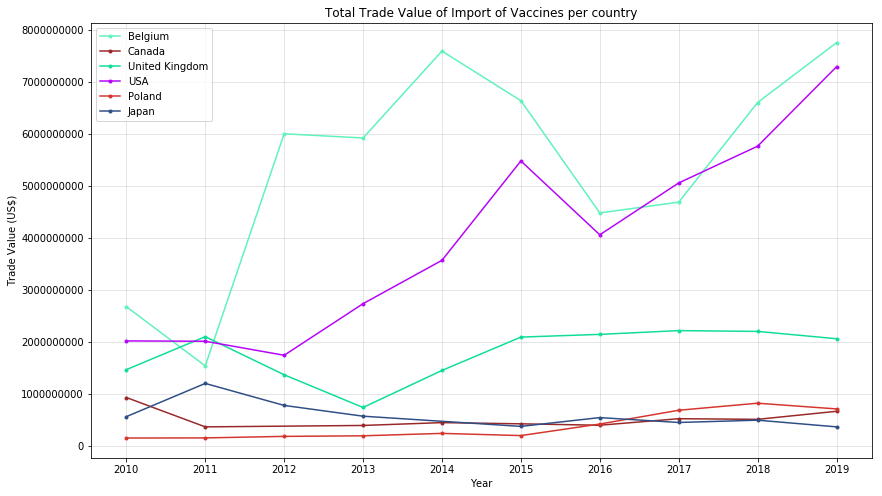

In [28]:
np.random.seed(42)

plt.figure(figsize=(14,8))
for country in c_list:
    cntry = top_importers_all_years[top_importers_all_years['Reporter'] == country]['Trade Value (US$)']
    plt.plot(cntry.sort_index(axis=0), marker='.', color=np.random.rand(3,), label=country)
plt.xlabel('Year')
plt.xticks(list(df.Year.unique()))
plt.ylabel('Trade Value (US$)')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Total Trade Value of Import of Vaccines per country')
plt.legend(loc='best')
plt.grid(True, alpha=0.4)
plt.show()

We can also visualize the results for a specific year:

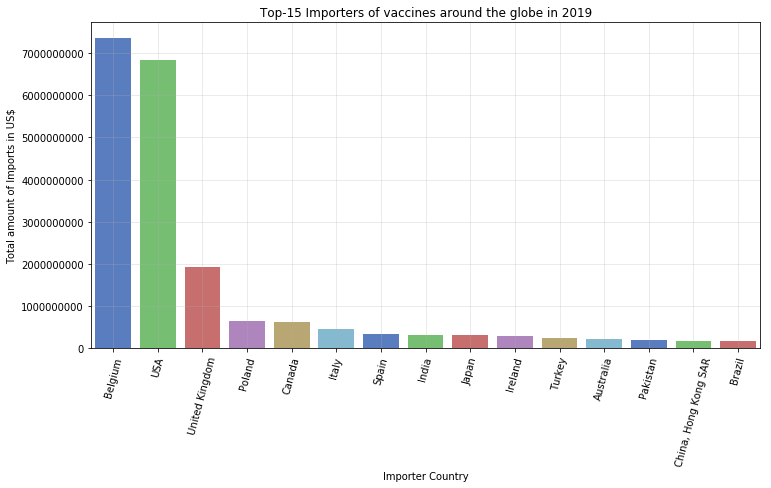

In [29]:
barplotTopnCountries(df=top_importers_2019, feature='Trade Value (US$)',
                      topn=topn, kind='Import', year=year, figsize=(12,6))

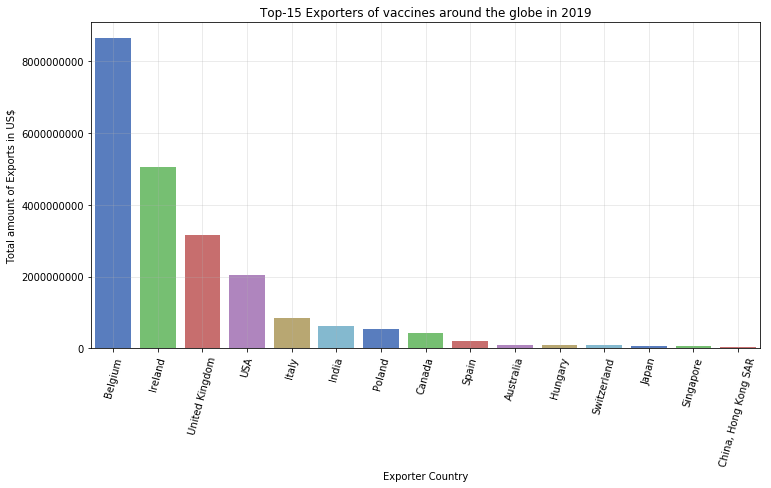

In [30]:
barplotTopnCountries(df=top_exporters_2019, feature='Trade Value (US$)',
                      topn=topn, kind='Export', year=year, figsize=(12,6))

For 2019 we can see that - except the first three countries (Belgium, USA, UK) - the rest of the countries seem to import much less compared with the top-3 importers. At the same Ireland appears to had a huge exporting activity on 2019. 

## Part 3 - Main analysis (Times Series with ARIMA & Recurrent Neural Networks)

In this part we are going to focus only at United Kingdom as our base country and perform an in depth analysis about the countries that UKise trading with, attempting to identify interesting patterns in the results. This is going to be done in two different parts. In the first part we will focus in the variations of imports by month, i.e. we will create Time Series object for the base country, where each observation will be the the Total Value of imports in a specific time point. The second part will focus on Network Analysis.

### Time Series

First we are creating the objects that will contain all the information that we need for our analysis. Each object is going to represent a country and in our analysis, as we mentioned previously, we will focus on United Kingdom - but we will attempt to make the codebase as robust as possible, so that the same analysis can be easily performed for any other country. 

At this point we will leverage the class **VaccinesTradeNetwork** which is a class that will allow us to create our analysis without having to include the code snipets in the notebook. If you want more information regarding how this class is organized, feel free to have a look at the repository.

In [16]:
# Create an object for United Kingdom 
united_kingdom = VaccinesTradeNetwork(df, country='United Kingdom')

Now we are focusing in the cases that the UK is our base country and take into consideration all data that 1) UK is the importer country of vaccines or 2) other countries exporting **to** UK (and thus that makes UK again the importer country). This has been implemented in the createFlowDF method, in the VaccinesTradeNetwork **VaccinesTradeNetwork** class. If you would like to change our analysis to exports, we could just change the _tradeflow_ parameter.

In [17]:
united_kingdom_imports_df = united_kingdom.createFlowDF(tradeflow='Imports',
                                                        source='Reporter',
                                                        target='Partner')

In [18]:
united_kingdom_ts = united_kingdom.generateTimeSeries(partner_country='USA', timeframe='month')

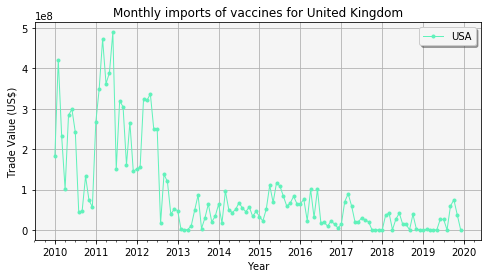

In [19]:
plt.rcParams['axes.facecolor'] = 'whitesmoke'
united_kingdom.plotTimeSeries(partner_list=['USA'], timeframe='month')

Figure 1.1

Our forecasting task will be separated into two parts. We will implement an ARIMA model to predict our values for 2019, based on the values that we have for the period 2010-2018. The second part will have the same goal but this time we will construct a Recurrent Neural Network (RNN) to make the predictions. Finally, we will compare the outputs of both methods and see which one is better for our forecasting task.

### Fitting an ARIMA model

At this stage we are going to fit an _ARIMA_ (Autoregressive Integrated Moving Average) model to forecast the 2019 Trade Value of UK imports of Vaccines from the USA.


ARIMA(p,d,q) is a statistical method(model) for Time Series analysis, especially around forecasting future points of a series of observations or just getting a better understanding of our data (e.g. a trend in the data).

The main components of an ARIMA model, are:
    
 **1.**   AR (Autoregression): This means that the model is leveraging the dependent relationship between an observation and some number of lagged observations (i.e. we are regressing the variable of interest on its on prior values).
 
 **2.**   I (Integrated): This is a common step to make the Time Series stationary, where we are subtracting an observation from an observation at the previous time step.
 
 **3.**   MA (Moving Average): The specification indicating that the predictor variable depends linearly on current/past observations. 
 
 **4.**   p: Number of lag observations in the model (lag order).
 
 **5.**   d: Number of times we subtracted past values from the data (degree of differencing).
 
 **6.**   q: Order of the moving average window (moving average).
 
In the next few steps our task is to identify the values of parameters p,d,q from above.

In [37]:
from pandas.tools.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

Now before we start building the model we should make sure that we are not violating any assumptions regarding ARIMA models. One of these assumptions is that our Time Series is stationary (i.e. the mean and the variance remains constant over time).

By looking at Figure 1.1 we can see that the time series in our case is not stationary and we have a decreasing trend, along with seasonal trends.




At first we look at the autocorrelation plot of the time series. This plot helps us identify a statistically significant amount of lags for the time series (i.e the lag order). This can be identified by looking at which point our series is between the dashes, which is the significant range.



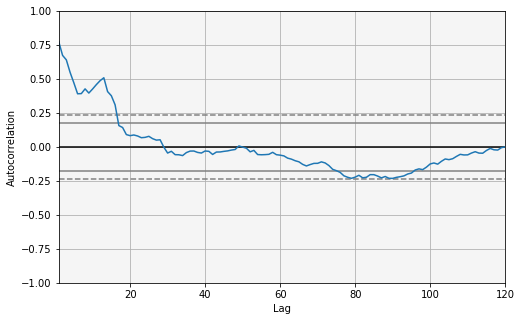

In [38]:
plt.figure(figsize = (8,5))
autocorrelation_plot(united_kingdom_ts['Trade Value (US$)'])

By looking at the plot we can infer that there is a positive correlation between lags 1-30, but it seems to be significant at the first 1 to 18 lags.
Thus a good starting point would be at 12 lags, which correspond to window of an observation lagged to its value at the previous year.

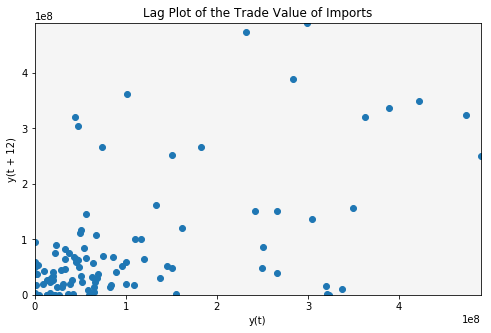

In [39]:
lag_order = 12

# Create a Lag plot
tnf.create_lag_plot(united_kingdom_ts['Trade Value (US$)'], lag = lag_order)

A lag plot is a special type of scatter plot with the two variables (X,Y) “lagged”.

A “lag” is a fixed amount of passing time; One set of observations in a time series is plotted (lagged) against a second, later set of data. 
The kth lag is the time period that happened “k” time points before time i.
(reference: https://www.statisticshowto.datasciencecentral.com/lag-plot/)

In our case we can see that we have a positive correlation and there is a linear pattern (suggesting autocorellation) between time t and t-k where k = lag order.

To check and evaluate the time series for stationarity we will be using a custom functions that is using the Dickey-Fuller test.In this test, our null hypothesis is that the Time Series is non-stationary.

Results of Dickey-Fuller Test:
Test Statistic                  -1.725599
P-value                          0.417973
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


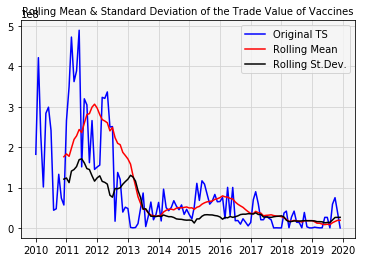

In [40]:
tnf.stationarity_checking(df=united_kingdom_ts['Trade Value (US$)'], window=12)

We can see that our time series is not stationary yet, as the test statistic is more that the critical values. Therefore we fail to reject the null hypothesis.

The reason why this time series is not stationary lies to the fact that we have a clear trend and seasonality in our data. One of the most common ways to resolve this issue is by differencing (point 2 at ARIMA model explanation above).Hence, when it's time to run the ARIMA model we have to make sure to include an **'I'** (integrated) parameter - which will give us the value of the 'd' paremeter.

Now to define the values for 'p' and 'q', we will use ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function). The ACF is helping us to measure the correlation of our time series with a lagged version of itself, for a specific lag. The PACF is similar to ACF but we are also excluding the variations explained already between an observation and its lagged value.


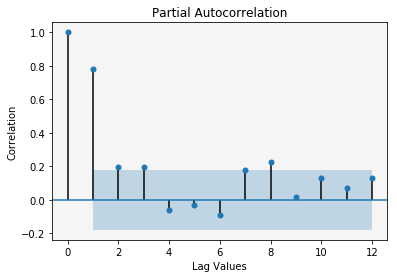

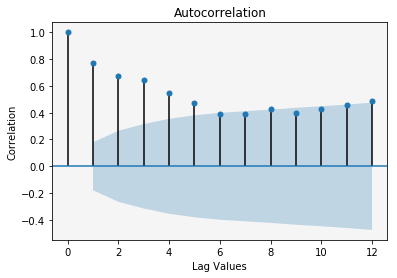

In [41]:
# Partial Autocorrelation Plot
tnf.plot_acf_pacf(united_kingdom_ts['Trade Value (US$)'], lag=lag_order, kind='pacf')

# Autocorrelation plot
tnf.plot_acf_pacf(united_kingdom_ts['Trade Value (US$)'], lag=lag_order, kind='acf')

The ACF and PACF plots indicating that we have clear statistical significance for lags 1 or 2.

Now we are going to split our dataset into train and test sets, where the training set will contain the data for period 2010-2018, and the test set will contain data for 2019. Our task will be - base on the training data - how well we can predict the values for 2019.

In [42]:
train, test = tnf.split_test_train(united_kingdom_ts['Trade Value (US$)'], num_months_test=12)

In [43]:
train.shape, test.shape

((108,), (12,))

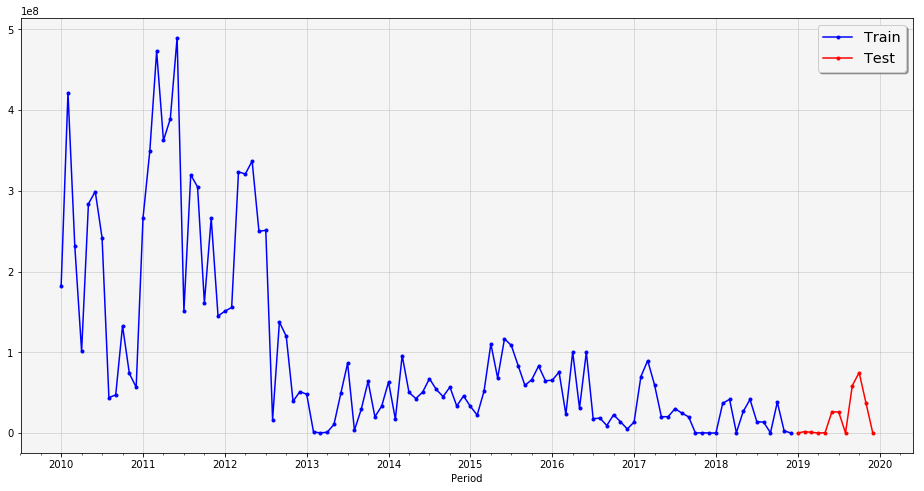

In [44]:
# Plot train and test sets
plt.figure(figsize=(16,8))
train.plot(marker = '.', color = 'blue', label = 'Train')
test.plot(marker = '.', color = 'red', label = 'Test')
plt.legend(loc = 'best', shadow = True, fontsize = 'x-large')
plt.grid(True, alpha=0.5)
plt.show()

In [45]:
# Create an ARIMA model
p = lag_order
d = 1
q = 0

predicted = []
series_updated = [x for x in train]

for t in range(len(test)):
    model = ARIMA(series_updated, order = (p,d,q))
    model_output = model.fit(disp=0)
    pred = model_output.forecast()
    yhat = pred[0]
    predicted.append(yhat)
    obs = test[t]
    series_updated.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=8740112.815823, expected=64449.000000
predicted=1546923.021681, expected=1806453.000000
predicted=-1473332.432353, expected=846430.000000
predicted=-9763878.009910, expected=124498.000000
predicted=-1950053.550863, expected=356123.000000
predicted=13720054.022095, expected=26184844.000000
predicted=10799688.545238, expected=26145772.000000
predicted=11208181.913613, expected=141569.000000
predicted=6026921.287661, expected=58903494.000000
predicted=34842342.668148, expected=74932830.000000
predicted=43445190.059854, expected=37295621.000000
predicted=34383426.347737, expected=43100.000000


RMSE: 22944519.578335874


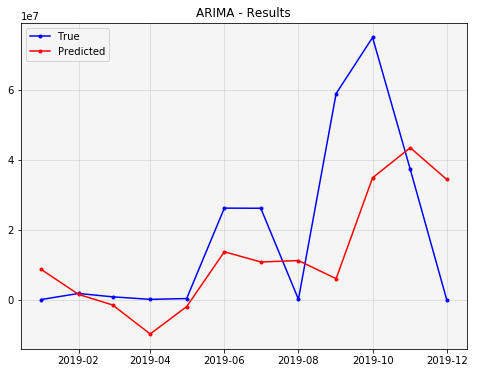

In [49]:
# Compare the predictions visually
plt.figure(figsize=(8,6))
plt.plot(test, marker='.', color= 'blue', label='True')
plt.plot(pd.Series(predicted, index=test.index), marker='.', color='red', label='Predicted')
plt.grid(True, alpha=0.4)
plt.title('ARIMA - Results')
plt.legend(loc='best')

# Compute the Root Mean Squared Error
from sklearn.metrics import mean_squared_error
rms = np.sqrt(mean_squared_error(np.array(test), predicted))
print('RMSE: {0}'.format(rms))


Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). 
Residuals are a measure of how far from the regression line data points are; 
RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. 
Root mean square error is commonly used in climatology, forecasting, and regression analysis to verify experimental results.


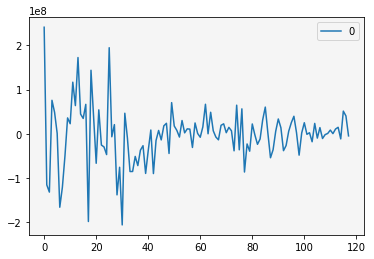

In [47]:
# Plot the residual errors
resid = pd.DataFrame(model_output.resid)
resid.plot()

                  0
count  1.180000e+02
mean  -1.795387e+06
std    6.431198e+07
min   -2.058092e+08
25%   -2.894557e+07
50%    2.003556e+06
75%    2.425983e+07
max    2.406329e+08


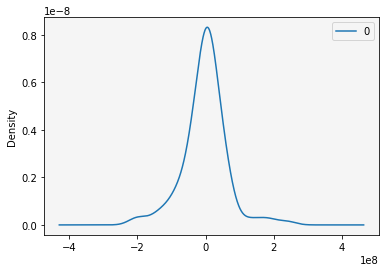

In [152]:
# Plot density of the residuals
resid.plot(kind='kde')
print(resid.describe())
# We can see that there is a slight bias in the prediction as there is non-zero mean
# in the residuals

### Fitting a Recurrent Neural Network (RNN)

In the case of Univariate Time Series, like the one we are facing in our problem, before we create the RNN architecture we have to complete some data preparation. Specifically, our task is to make the RNN to learn a function that it will take as input a series of observations (past steps) to predict the next observation(s).

In [20]:
# Architecture for the Neural Network

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Bidirectional

time_series_uk_to_usa = united_kingdom_ts['Trade Value (US$)']

In general is a good practice before we work with Neural Networks to normalize the data. In that case we are going to scale our data to values between 0 and 1.

In [21]:
# Split the series into train and test sets
# parameter num_months_test defines how many months we take as test data
train, test = tnf.split_test_train(time_series_uk_to_usa, num_months_test=12)
print(f'Shape of train is {train.shape}\nShape of test is {test.shape}')

Shape of train is (108,)
Shape of test is (12,)


In [22]:
train = train.values.reshape(-1, 1)

In [23]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

train_scaled = scaler.fit_transform(train)

C:\Users\george\AppData\Roaming\Python\Python36\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [24]:
prediction_window = 12

n_steps_past = 12
n_steps_future = 1
n_features = 1

In [29]:
X, y = tnf.split_into_samples(pd.Series(np.concatenate(train_scaled)),
                              n_steps_past=n_steps_past,
                              n_steps_future=n_steps_future)
print(f'Shape of X is {X.shape}\nShape of y is {y.shape}')

Shape of X is (96, 12)
Shape of y is (96, 1)


In [30]:
X = X.reshape((X.shape[0], n_steps_past, n_features))

In [31]:
# Define the model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps_past, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
# Train the model
model.fit(X, y, epochs=400, batch_size=64, verbose=1)

Epoch 1/400
96/96 [==============================] - 2s 16ms/step - loss: 0.1000
Epoch 2/400
96/96 [==============================] - 0s 213us/step - loss: 0.0924
Epoch 3/400
96/96 [==============================] - 0s 210us/step - loss: 0.0827
Epoch 4/400
96/96 [==============================] - 0s 211us/step - loss: 0.0760
Epoch 5/400
96/96 [==============================] - 0s 312us/step - loss: 0.0674
Epoch 6/400
96/96 [==============================] - 0s 207us/step - loss: 0.0629
Epoch 7/400
96/96 [==============================] - 0s 209us/step - loss: 0.0568
Epoch 8/400
96/96 [==============================] - 0s 312us/step - loss: 0.0510
Epoch 9/400
96/96 [==============================] - 0s 209us/step - loss: 0.0460
Epoch 10/400
96/96 [==============================] - 0s 208us/step - loss: 0.0438
Epoch 11/400
96/96 [==============================] - 0s 313us/step - loss: 0.0420
Epoch 12/400
96/96 [==============================] - 0s 205us/step - loss: 0.0406
Epoch 13/400
9

96/96 [==============================] - 0s 103us/step - loss: 0.0124
Epoch 197/400
96/96 [==============================] - 0s 208us/step - loss: 0.0136
Epoch 198/400
96/96 [==============================] - 0s 206us/step - loss: 0.0125
Epoch 199/400
96/96 [==============================] - 0s 303us/step - loss: 0.0152
Epoch 200/400
96/96 [==============================] - 0s 206us/step - loss: 0.0117
Epoch 201/400
96/96 [==============================] - 0s 209us/step - loss: 0.0122
Epoch 202/400
96/96 [==============================] - 0s 210us/step - loss: 0.0122
Epoch 203/400
96/96 [==============================] - 0s 209us/step - loss: 0.0132
Epoch 204/400
96/96 [==============================] - 0s 208us/step - loss: 0.0107
Epoch 205/400
96/96 [==============================] - 0s 208us/step - loss: 0.0130
Epoch 206/400
96/96 [==============================] - 0s 154us/step - loss: 0.0142
Epoch 207/400
96/96 [==============================] - 0s 210us/step - loss: 0.0148
Epoch 

96/96 [==============================] - 0s 295us/step - loss: 0.0106
Epoch 391/400
96/96 [==============================] - 0s 210us/step - loss: 0.0109
Epoch 392/400
96/96 [==============================] - 0s 210us/step - loss: 0.0092
Epoch 393/400
96/96 [==============================] - 0s 207us/step - loss: 0.0112
Epoch 394/400
96/96 [==============================] - 0s 208us/step - loss: 0.0092
Epoch 395/400
96/96 [==============================] - 0s 209us/step - loss: 0.0112
Epoch 396/400
96/96 [==============================] - 0s 258us/step - loss: 0.0114
Epoch 397/400
96/96 [==============================] - 0s 106us/step - loss: 0.0112
Epoch 398/400
96/96 [==============================] - 0s 209us/step - loss: 0.0106
Epoch 399/400
96/96 [==============================] - 0s 191us/step - loss: 0.0103
Epoch 400/400
96/96 [==============================] - 0s 207us/step - loss: 0.0129


In [33]:
# Reshape the test data
test_reshaped = test.values.reshape(-1, 1)
test_scaled = scaler.transform(test_reshaped)

In [34]:
# Add the last n_steps_past observations to predict the future values
test_series = np.concatenate((train_scaled[-n_steps_past:], test_scaled))

In [35]:
# For the predictions we take run through the n_steps_past values from the training
# data for the first iteration, then predict the next value in the series and this
# value the gets feed into the series to assist with the prediction of the next
# (and so on)
predictions = []
history = train_scaled[-n_steps_past:]
for i in range(n_steps_past):
    x_ser = history[i:i+n_steps_past].reshape((1, n_steps_past, n_features))
    yhat = model.predict(x_ser, verbose=0)
    history = np.vstack((history, yhat))
    predictions.append(scaler.inverse_transform(yhat))
    print(f'Predicted Value: {predictions[i][0]}, true value: {test_reshaped[i]}')

Predicted Value: [20377748.], true value: [64449]
Predicted Value: [22881688.], true value: [1806453]
Predicted Value: [24201638.], true value: [846430]
Predicted Value: [25324298.], true value: [124498]
Predicted Value: [27898158.], true value: [356123]
Predicted Value: [29700716.], true value: [26184844]
Predicted Value: [30993386.], true value: [26145772]
Predicted Value: [32706492.], true value: [141569]
Predicted Value: [34189980.], true value: [58903494]
Predicted Value: [36303308.], true value: [74932830]
Predicted Value: [36606524.], true value: [37295621]
Predicted Value: [37832760.], true value: [43100]


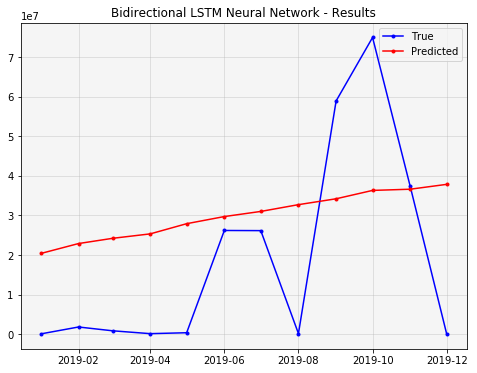

In [36]:
predicted = [i[0][0] for i in predictions]

# Compare the predictions visually
plt.figure(figsize=(8,6))
plt.plot(test[0:prediction_window], marker='.', color= 'blue', label='True')
plt.plot(pd.Series(predicted[0:prediction_window], index=test.index[0:prediction_window]),
         marker='.', color='red', label='Predicted')
plt.grid(True, alpha=0.4)
plt.title('Bidirectional LSTM Neural Network - Results')
plt.legend()